# **FDS - Final Project: Classification of Fake and Real Faces**

## **Data Augmentation + Saving Grad-CAM Images**

In this notebook, we study the abilities of the best performing models found during training, testing them against flipping, rotations, color changes and finally blurring. We also save a series of Grad-CAM images generated by the trained Custom CNN and ResNet-50.

#### Import libraries

In [ ]:
pip install grad-cam

In [ ]:
!pip install torchcam

In [3]:
import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from torchvision import models
from torchvision import transforms
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchcam.methods import SmoothGradCAMpp, GradCAM
from torchvision.transforms.functional import to_pil_image
import seaborn as sns
import cv2
from google.colab import drive
from torchvision.models import ResNet50_Weights # Import ResNet50_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR
import copy
from collections import defaultdict

Mount Google Drive for saving results later.

In [4]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive

Mounted at /content/drive


Set random seeds for reproducibility of results.

In [5]:
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#### Import and read dataset

In [6]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.75G/3.75G [02:49<00:00, 24.0MB/s]
100% 3.75G/3.75G [02:49<00:00, 23.7MB/s]


In [ ]:
!unzip 140k-real-and-fake-faces.zip -d /content/

In [8]:
train_df = pd.read_csv('/content/train.csv', index_col=0)
test_df = pd.read_csv('/content/test.csv', index_col=0)
valid_df = pd.read_csv('/content/valid.csv', index_col=0)
print('Train Dataset Paths and Labels')
display(train_df.head())
print('Test Dataset Paths and Labels')
display(test_df.head())
print('Validation Dataset Paths and Labels')
display(valid_df.head())

Train Dataset Paths and Labels


original_path     id  label label_str  \
0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  31355      1      real   
1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  02884      1      real   
2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  33988      1      real   
3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  53875      1      real   
4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  24149      1      real   

                   path  
0  train/real/31355.jpg  
1  train/real/02884.jpg  
2  train/real/33988.jpg  
3  train/real/53875.jpg  
4  train/real/24149.jpg

Test Dataset Paths and Labels


original_path     id  label label_str  \
0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  18233      1      real   
1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  54317      1      real   
2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  40155      1      real   
3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  12875      1      real   
4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  52543      1      real   

                  path  
0  test/real/18233.jpg  
1  test/real/54317.jpg  
2  test/real/40155.jpg  
3  test/real/12875.jpg  
4  test/real/52543.jpg

Validation Dataset Paths and Labels


original_path     id  label label_str  \
0  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  20001      1      real   
1  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  11264      1      real   
2  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  19817      1      real   
3  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  46851      1      real   
4  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  10411      1      real   

                   path  
0  valid/real/20001.jpg  
1  valid/real/11264.jpg  
2  valid/real/19817.jpg  
3  valid/real/46851.jpg  
4  valid/real/10411.jpg

Adjust paths in the `path` columns

In [9]:
# Base directory where images are stored
base_img_dir = '/content/real_vs_fake/real-vs-fake/'

# Combine the base path with the relative paths from the 'path' column
train_df['image_path'] = train_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
valid_df['image_path'] = valid_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
test_df['image_path'] = test_df['path'].apply(lambda x: os.path.join(base_img_dir, x))

#### Visualize some images

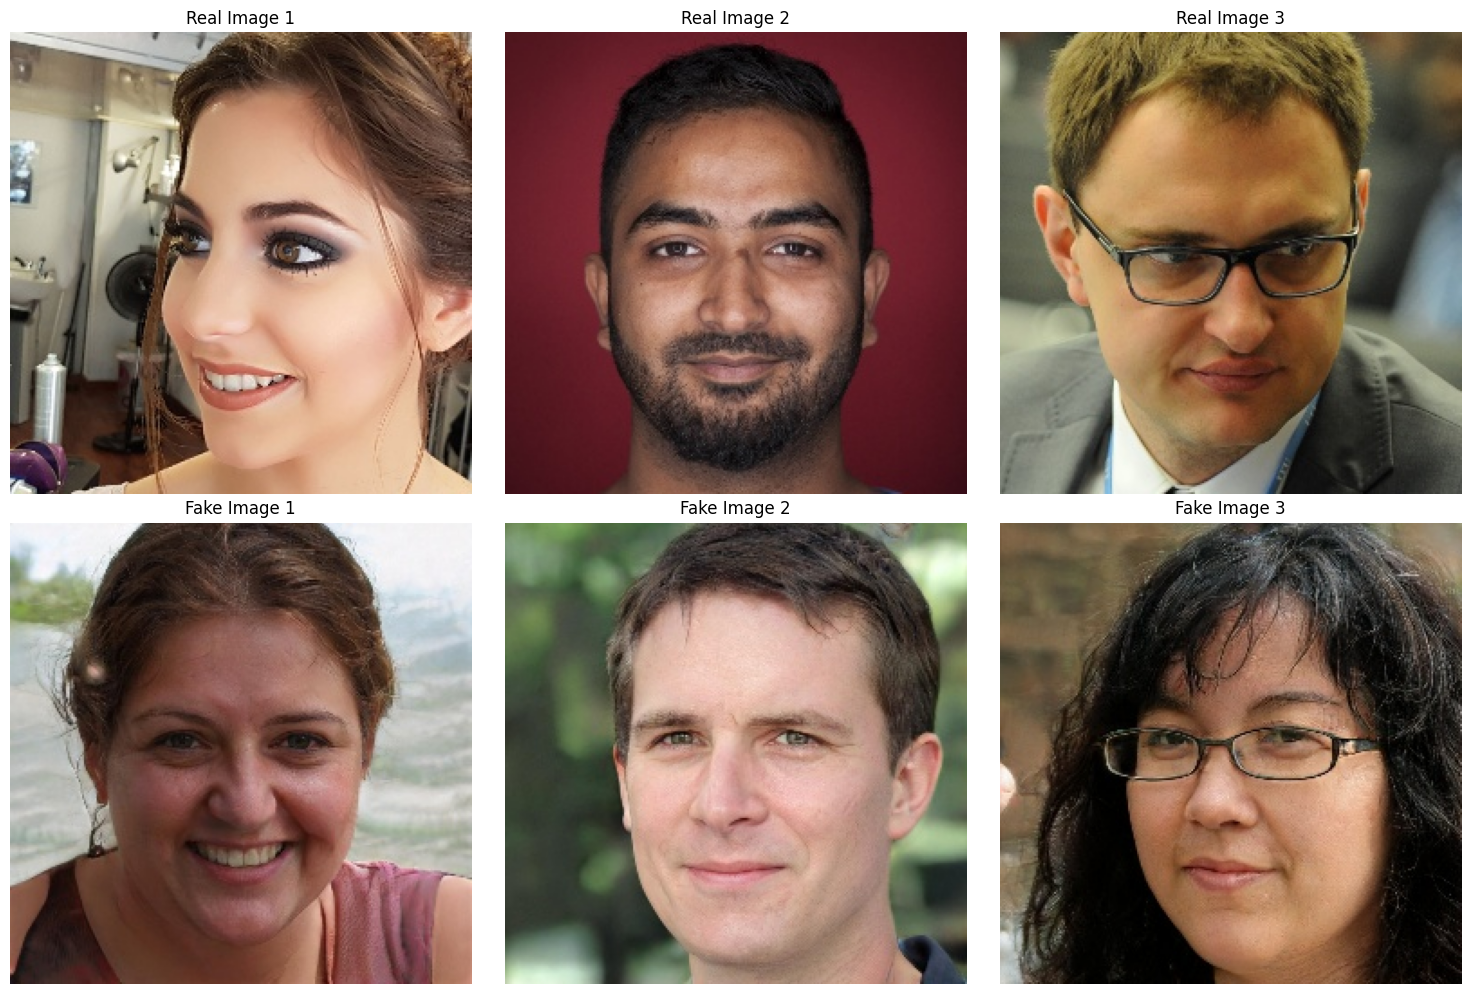

In [10]:
# Pick 3 real and 3 fake images to show
real_imgs_to_show = random.sample(list(train_df[train_df.label == 1].image_path), 3)
fake_imgs_to_show = random.sample(list(train_df[train_df.label == 0].image_path), 3)

# Open images using PIL
real_images = [Image.open(path) for path in real_imgs_to_show]
fake_images = [Image.open(path) for path in fake_imgs_to_show]

# Display images side by side using Matplotlib
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Add real images in the first row
for ax, img, title in zip(axes[0], real_images, ["Real Image 1", "Real Image 2", "Real Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

# Add fake images in the second row
for ax, img, title in zip(axes[1], fake_images, ["Fake Image 1", "Fake Image 2", "Fake Image 3"]):
    ax.imshow(img)
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()

#### Create FaceDataset class
We create a FaceDataset class that can be passed to a DataLoader, which will take care of batching and shuffling.

In [11]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        '''
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels
            transform (callable, optional): Optional transform to be applied on a sample
        '''
        self.dataframe = dataframe  # Store the dataframe
        self.transform = transform  # Store the transform (if present)

    def __len__(self):
        return len(self.dataframe)  # Return the length of the dataframe

    def __getitem__(self, idx):
        # Get the image path and label from the dataframe
        img_path = self.dataframe.iloc[idx].image_path
        label = int(self.dataframe.iloc[idx].label)  # Label is 0 or 1 (fake or real)

        # Open the image using PIL
        image = Image.open(img_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and label

### Custom CNN

Here is the architecture of the Custom CNN we built:

In [14]:
class CustomCNN(nn.Module):

    def __init__(self):
        super(CustomCNN, self).__init__()

        # First Convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization

        # ReLU activation
        self.relu = nn.ReLU()

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization

        # Third Convolutional layer
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization

        # Fourth Convolutional layer
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  # Batch normalization

        # Flatten Layer: Converts 2D feature map into 1D vector
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Fully Connected Layer 1: 512 neurons
        self.fc1 = nn.Linear(256 * 32 * 32, 512)

        # Fully Connected Layer 2: 256 neurons
        self.fc2 = nn.Linear(512, 256)

        # Fully Connected Layer 3: 2 neurons
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        # First Convolutional layer
        x = self.pool(self.relu(self.bn1(self.conv1(x))))

        # Second Convolutional layer
        x = self.relu(self.bn2(self.conv2(x)))

        # Third Convolutional layer
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        # Fourth Convolutional layer
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        # Flatten Layer
        x = self.flatten(x)

        # Fully Connected Layer 1
        x = self.dropout(self.relu(self.fc1(x)))

        # Fully Connected Layer 2
        x = self.dropout(self.relu(self.fc2(x)))

        # Fully Connected Layer 3
        x = self.fc3(x)

        return x



Here we define transformations to pass the input images to our model. We also define a transform for data augmentation purposes, which will be used later. `model = CustomCNN()` initializes the CNN.

In [25]:
# Specify input transformations to pass it to the model
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image if needed
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Data augmentation transforms
augmentation_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image if needed
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(20),  # Random rotation within a 20-degree range
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.ToTensor(),  # Convert pytorch tensor and scale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Initialize the custom CNN
model = CustomCNN()

In [26]:
results_dict = torch.load('/content/drive/MyDrive/CustomCNN/results_CE_SGD_0001_mom.pth')
model_weights = results_dict['model_state_dict']
model.load_state_dict(model_weights)

<ipython-input-26-db2502ce8f97>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_dict = torch.load('/content/drive/MyDrive/CustomCNN/results_CE_SGD_0001_mom.pth')


<All keys matched successfully>

Next, we make training, validation, test dataset and dataloader instances:

In [27]:
# Create Dataset instances for train, validation, and test sets
train_dataset = FaceDataset(dataframe=train_df, transform=augmentation_transform)
valid_dataset = FaceDataset(dataframe=valid_df, transform=transform)
test_dataset = FaceDataset(dataframe=test_df, transform=transform)

# Create DataLoader instances for efficient batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Switch to GPU if available:

In [28]:
# Set device to cuda if it is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Move model to the right device
model.to(device)

CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (

### Experiment Functions

To keep the notebook organized, we made specific functions that handle the execution of the experiments, creating and saving result figures for performance evaluation and visualization, and create grad-cam heatmaps.

* `experiment`: function that performs training, validation, testing, prints results and returns the trained model + full results in a dictionary
* `get_grad_cam_images`: function that computes the Grad-CAM heatmaps for a selection of images
* `plot_figures`: function that generates plots with loss and accuracy curves, ROC curve, Precision-Recall curve, confusion matrices

In [19]:
def experiment(train_loader, valid_loader, test_loader, model, loss_function, optimizer, num_epochs, lr, weight_decay=0, momentum=0):
    '''
    Function that performs training, validation and testing on a model, given a loss function, optimizer, and hyper-parameters.
    The function returns the results of training the model
    Args:
    - train_loader (DataLoader): DataLoader for training set
    - valid_loader (DataLoader): DataLoader for validation set
    - test_loader (DataLoader): DataLoader for test set
    - model (nn.Module): Model to train
    - loss_function (nn.Module): Loss function to use
    - optimizer (torch.optim): Optimizer to use
    - lr (float): Learning rate for optimizer
    - weight_decay (float): Weight decay for optimizer
    - momentum (float): Momentum for optimizer
    - num_epochs (int): Number of epochs to train for
    Returns:
    - model (nn.Module): Trained model
    - results (dict): Dictionary containing training and validation loss and accuracy for each epoch + other results
    '''
    # Set device to cuda if it is available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Move model to the right device
    model.to(device)

    # Define Loss function
    if loss_function == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
    elif loss_function == 'BCEWithLogitsLoss':
        criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy loss

    # Define optimizer function
    if optimizer == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # Adam optimizer
    elif optimizer == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum) # SGD optimizer

    # Initialize lists for accuracies, losses, Grad-CAM images, probabilities of predicting class 1
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    true_labels = []
    pred_labels = []
    probs = []

    num_epochs = num_epochs

    # Iterate over the epochs
    for epoch in range(num_epochs):
        # Training Phase
        model.train()  # Set the model to training mode
        train_running_loss = 0.0
        correct, total = 0, 0
        prob = []

        # Iterate over the batches
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU if available

            # Set parameter gradients to zero
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            if loss_function == 'BCEWithLogitsLoss':
                # convert labels to float and ensure single-channel output
                loss = criterion(outputs[:, 1], labels.float())
            elif loss_function == 'CrossEntropyLoss':
                loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Optimization
            optimizer.step()

            # Increase training loss
            train_running_loss += loss.item()

            # Calculate accuracy
            predicted = torch.max(outputs, 1)[1]  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate average loss for the training epoch
        avg_train_loss = train_running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate training accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch+1}: Training Loss = {avg_train_loss:.4f}, Training Accuracy = {train_accuracy:.4f}')

        # Validation Phase
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        val_correct, val_total = 0, 0

        # Initialize label lists for this epoch
        epoch_true_labels = []
        epoch_pred_labels = []

        # Iterate over the batches in valid_loader
        for val_inputs, val_labels in valid_loader:
            # Move to device
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

            # Forward pass
            val_outputs = model(val_inputs)

            with torch.no_grad():  # no need to compute gradients here

                # Compute loss
                if loss_function == 'BCEWithLogitsLoss':
                    # convert labels to float and ensure single-channel output
                    val_loss = criterion(val_outputs[:, 1], val_labels.float())
                elif loss_function == 'CrossEntropyLoss':
                    val_loss = criterion(val_outputs, val_labels)

                # Increase validation loss
                val_running_loss += val_loss.item()

                # Calculate accuracy
                val_predicted = torch.max(val_outputs, 1)[1]  # Get predicted class
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

                # Memorize true and predicted labels for explainability
                epoch_true_labels.extend(val_labels.cpu().numpy())
                epoch_pred_labels.extend(val_predicted.cpu().numpy())

            # Calculate probabilities for prediction = class 1 (real) using softmax
            prob.extend(torch.softmax(val_outputs, dim=1)[:, 1].cpu().detach().numpy())

        # Calculate average loss for the validation epoch
        avg_val_loss = val_running_loss / len(valid_loader)
        val_losses.append(avg_val_loss)

        # Calculate validation accuracy
        val_accuracy = val_correct / val_total
        val_accuracies.append(val_accuracy)

        # Append results to the probs, true_labels, pred_labels lists
        probs.append(prob)
        true_labels.append(epoch_true_labels)
        pred_labels.append(epoch_pred_labels)

        print(f'Epoch {epoch+1}: Validation Loss = {avg_val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}')

    print('Finished Training')

    # confusion matrix
    conf_matrix = confusion_matrix(true_labels[-1], pred_labels[-1])

    # Get predictions on the test set
    model.eval()

    with torch.no_grad(): # no need to compute gradients here

        test_predictions = []
        test_true_labels = []

        # Iterate over the batches in test_loader
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # move to device
            outputs = model(images) # compute output
            _, predicted = torch.max(outputs, 1) # get prediction
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(test_true_labels, test_predictions)
    precision = precision_score(test_true_labels, test_predictions, average='binary')
    recall = recall_score(test_true_labels, test_predictions, average='binary')
    f1 = f1_score(test_true_labels, test_predictions, average='binary')
    roc_auc = roc_auc_score(test_true_labels, test_predictions)

    # Print the results
    print('\nTest Results')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    print(f'Test ROC AUC: {roc_auc:.4f}')

    # Test Confusion Matrix
    test_conf_matrix = confusion_matrix(test_true_labels, test_predictions)

    report = classification_report(true_labels[-1], pred_labels[-1], target_names=['Fake', 'Real'])
    print("\nClassification Report:\n", report)

    # Put results in a dictionary
    results = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'true_labels': true_labels,
        'pred_labels': pred_labels,
        'probs': probs,
        'test_true_labels': test_true_labels,
        'test_predictions': test_predictions,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'conf_matrix': conf_matrix,
        'test_conf_matrix': test_conf_matrix
      }

    return model, results

In [46]:

def get_grad_cam_images(model, transform, target_layer, real_images, fake_images, path):
    '''
    Function that takes a trained model and returns Grad-CAM results for a selection of real and fake image paths
    Args:
    - model (nn.Module): Trained model
    - transform (torchvision.transforms): Image transformations
    - target_layer (nn.Module): Target layer for Grad-CAM
    - real_images (list): List of real image paths
    - fake_images (list): List of fake image paths
    - path (str): Path to save Grad-CAM images
    Returns:
    - None
    '''
    # Set the model to evaluation mode
    model.eval()

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Function to process an image and generate Grad-CAM heatmap
    def generate_gradcam_overlay(img_path, target_class):
        # Load and preprocess the image
        image = Image.open(img_path).convert('RGB')
        img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Convert the image to a NumPy array for visualization
        img_for_visualization = np.array(image.resize((256, 256))) / 255.0  # Scale to [0, 1]

        # Generate Grad-CAM heatmap
        grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(target_class)])
        heatmap = grayscale_cam[0, :]  # Extract the heatmap

        # Overlay heatmap on the image
        superimposed_img = show_cam_on_image(img_for_visualization, heatmap, use_rgb=True)

        # Get model prediction
        with torch.no_grad():
            output = model(img_tensor)
            pred_class = output.argmax(dim=1).item()

        return superimposed_img, pred_class

    # Create subplots
    fig, axes = plt.subplots(2, len(real_images), figsize=(15, 10))

    # First row: Real images
    for i, img_path in enumerate(real_images):
        target_class = 1  # Actual label for real images
        superimposed_img, pred_class = generate_gradcam_overlay(img_path, target_class)
        axes[0, i].imshow(superimposed_img)
        axes[0, i].set_title(f'Real Image {i+1}\nPred: {pred_class}, Actual: {target_class}')
        axes[0, i].axis('off')

    # Second row: Fake images
    for i, img_path in enumerate(fake_images):
        target_class = 0  # Actual label for fake images
        superimposed_img, pred_class = generate_gradcam_overlay(img_path, target_class)
        axes[1, i].imshow(superimposed_img)
        axes[1, i].set_title(f'Fake Image {i+1}\nPred: {pred_class}, Actual: {target_class}')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.savefig(path)
    plt.show()

# This Grad-CAM function studies WHY a model made a certain prediction (focusing on predicted class rather than true clas)
# It just returns the image without printing it
def Grad_CAM(model, transform, target_layer, image):
    '''
    Function that takes a trained model, an image and returns the Grad-CAM heatmap for that image
    Args:
    - model (torch.nn.Module): Trained model
    - transform (torchvision.transforms): Image transformations
    - target_layer (torch.nn.Module): Target layer for Grad-CAM
    - image (str): Path to image
    Returns:
    -
    '''
    # Set the model to evaluation mode
    model.eval()

    # Initialize Grad-CAM
    cam = GradCAM(model=model, target_layers=[target_layer])

    # Function to process an image and generate Grad-CAM heatmap
    def generate_gradcam_overlay(img_path):

        # Load and preprocess the image
        image = Image.open(img_path).convert('RGB')
        img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Get model prediction
        with torch.no_grad():
            output = model(img_tensor)
            pred_class = output.argmax(dim=1).item()

        target_class = pred_class # set the target class (which Grad-CAM focuses on) as the predicted class to understand why the model made a prediction

        # Convert the image to a NumPy array
        img = np.array(image.resize((256, 256))) / 255.0  # Scale to [0, 1]

        # Generate Grad-CAM heatmap
        grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(target_class)])
        heatmap = grayscale_cam[0, :]  # Extract the heatmap

        # Overlay heatmap on the image
        superimposed_img = show_cam_on_image(img, heatmap, use_rgb=True)

        return superimposed_img, pred_class

    return generate_gradcam_overlay(image)

In [21]:
def plot_figures(results, path, num_epochs):
    '''
    Function that, given training, validation and test results, plots and saves images
    Args:
    - results (dict): Dictionary containing training, validation and test results
    - path (str): Path to save images
    - num_epochs (int): Number of epochs
    Returns:
    - None
    '''

    train_losses = results['train_losses']
    val_losses = results['val_losses']
    train_accuracies = results['train_accuracies']
    val_accuracies = results['val_accuracies']
    true_labels = results['true_labels']
    pred_labels = results['pred_labels']
    probs = results['probs']
    conf_matrix = results['conf_matrix']
    test_conf_matrix = results['test_conf_matrix']

    plt.figure(figsize=(15, 16))

    # Training and validation loss curves
    plt.subplot(3, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Trainining Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Training and validation accuracy curves
    plt.subplot(3, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # ROC curve
    fpr, tpr, _ = roc_curve(true_labels[-1], probs[-1])

    plt.subplot(3, 2, 3)
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(true_labels[-1], probs[-1])

    plt.subplot(3, 2, 4)
    plt.plot(recall, precision, color='green', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()

    # Confusion Matrix Validation

    # Plot the confusion matrix
    plt.subplot(3,2,5)
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.title('Validation Confusion Matrix (last epoch)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Confusion Matrix Testing
    plt.subplot(3,2,6)
    sns.heatmap(test_conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=True, xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(path)
    plt.show()

In [23]:
def testing(test_loader, model):
    '''
    Function that tests a trained model on a test set
    Args:
    - test_loader (DataLoader): DataLoader for test set
    - model (nn.Module): Trained model
    Returns:
    - None
    '''
    # Get predictions on the test set
    model.eval()

    with torch.no_grad(): # no need to compute gradients here

        test_predictions = []
        test_true_labels = []

        # Iterate over the batches in test_loader
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device) # move to device
            outputs = model(images) # compute output
            _, predicted = torch.max(outputs, 1) # get prediction
            test_predictions.extend(predicted.cpu().numpy())
            test_true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(test_true_labels, test_predictions)
    precision = precision_score(test_true_labels, test_predictions, average='binary')
    recall = recall_score(test_true_labels, test_predictions, average='binary')
    f1 = f1_score(test_true_labels, test_predictions, average='binary')
    roc_auc = roc_auc_score(test_true_labels, test_predictions)
    test_conf_matrix = confusion_matrix(test_true_labels, test_predictions)

    # Print the results
    print('\nTest Results')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1 Score: {f1:.4f}')
    print(f'Test ROC AUC: {roc_auc:.4f}')

### Data Augmentation Experiments

First, we see how our trained CNN performs on augmented images. If it performs badly, we perform data augmentation to make the model more robust.

In [24]:
testing(train_loader, model) # we use the train_loader here just to try it because it contains the augmented transformations


Test Results
Test Accuracy: 0.5000
Test Precision: 0.5000
Test Recall: 1.0000
Test F1 Score: 0.6667
Test ROC AUC: 0.5000


The results look very bad, so we are going to fine-tune it:

In [30]:
augmented_model = copy.deepcopy(model)
augmented_model, augmented_results = experiment(train_loader, valid_loader, test_loader, augmented_model, loss_function = 'CrossEntropyLoss', optimizer='SGD', lr=0.0001, momentum=0.9, num_epochs=2)

Epoch 1: Training Loss = 0.6931, Training Accuracy = 0.4990
Epoch 1: Validation Loss = 0.6932, Validation Accuracy = 0.5000
Epoch 2: Training Loss = 0.6932, Training Accuracy = 0.4990
Epoch 2: Validation Loss = 0.6932, Validation Accuracy = 0.5000
Finished Training

Test Results
Test Accuracy: 0.5000
Test Precision: 0.5000
Test Recall: 1.0000
Test F1 Score: 0.6667
Test ROC AUC: 0.5000

Classification Report:
               precision    recall  f1-score   support

        Fake       0.00      0.00      0.00     10000
        Real       0.50      1.00      0.67     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can see that the model clearly struggles with augmented images, apparently classifying all images as real and not recognising fake ones at all. This means that the model likely had some overfitting on the not augmented images.

We could try again, this time with different parameters, to see if the results change.

In [31]:
augmented_model2= copy.deepcopy(model)
augmented_model2, augmented_results2 = experiment(train_loader, valid_loader, test_loader, augmented_model2, loss_function = 'BCEWithLogitsLoss', optimizer='Adam', lr=0.001, num_epochs=2)

Epoch 1: Training Loss = 0.6932, Training Accuracy = 0.4984
Epoch 1: Validation Loss = 0.6932, Validation Accuracy = 0.5000
Epoch 2: Training Loss = 0.6932, Training Accuracy = 0.4983
Epoch 2: Validation Loss = 0.6932, Validation Accuracy = 0.5000
Finished Training

Test Results
Test Accuracy: 0.5000
Test Precision: 0.5000
Test Recall: 1.0000
Test F1 Score: 0.6667
Test ROC AUC: 0.5000

Classification Report:
               precision    recall  f1-score   support

        Fake       0.00      0.00      0.00     10000
        Real       0.50      1.00      0.67     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Sicne our pretrained models don't perform well, we could try training them on augmented images from the start. The problem could lie in the overfitting.

In [32]:
augmented_model3 = CustomCNN()
augmented_model3, augmented_results3 = experiment(train_loader, valid_loader, test_loader, augmented_model3, loss_function = 'CrossEntropyLoss', optimizer='SGD', lr=0.0001, num_epochs=2, momentum=0.9)

Epoch 1: Training Loss = 0.6360, Training Accuracy = 0.6363
Epoch 1: Validation Loss = 0.6150, Validation Accuracy = 0.6558
Epoch 2: Training Loss = 0.5721, Training Accuracy = 0.7037
Epoch 2: Validation Loss = 0.5354, Validation Accuracy = 0.7295
Finished Training

Test Results
Test Accuracy: 0.7288
Test Precision: 0.8025
Test Recall: 0.6069
Test F1 Score: 0.6911
Test ROC AUC: 0.7288

Classification Report:
               precision    recall  f1-score   support

        Fake       0.68      0.85      0.76     10000
        Real       0.80      0.61      0.69     10000

    accuracy                           0.73     20000
   macro avg       0.74      0.73      0.73     20000
weighted avg       0.74      0.73      0.73     20000



This time, the model is performing better, so we will keep training it for another 3 epochs.

In [34]:
augmented_model3, augmented_results3_continuation = experiment(train_loader, valid_loader, test_loader, augmented_model3, loss_function = 'CrossEntropyLoss', optimizer='SGD', lr=0.0001, num_epochs=3, momentum=0.9)

Epoch 1: Training Loss = 0.5406, Training Accuracy = 0.7285
Epoch 1: Validation Loss = 0.4908, Validation Accuracy = 0.7590
Epoch 2: Training Loss = 0.5182, Training Accuracy = 0.7443
Epoch 2: Validation Loss = 0.4634, Validation Accuracy = 0.7830
Epoch 3: Training Loss = 0.4949, Training Accuracy = 0.7617
Epoch 3: Validation Loss = 0.4337, Validation Accuracy = 0.7996
Finished Training

Test Results
Test Accuracy: 0.8004
Test Precision: 0.8025
Test Recall: 0.7970
Test F1 Score: 0.7997
Test ROC AUC: 0.8004

Classification Report:
               precision    recall  f1-score   support

        Fake       0.80      0.81      0.80     10000
        Real       0.80      0.79      0.80     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



We could try improving it some more, this time increasing the learning rate by 0.0004 and running another 2 epochs:

In [35]:
augmented_model4, augmented_results4 = experiment(train_loader, valid_loader, test_loader, augmented_model3, loss_function = 'CrossEntropyLoss', optimizer='SGD', lr=0.0005, num_epochs=2, momentum=0.9)

Epoch 1: Training Loss = 0.5560, Training Accuracy = 0.7160
Epoch 1: Validation Loss = 0.4729, Validation Accuracy = 0.7751
Epoch 2: Training Loss = 0.5170, Training Accuracy = 0.7468
Epoch 2: Validation Loss = 0.4401, Validation Accuracy = 0.7954
Finished Training

Test Results
Test Accuracy: 0.7903
Test Precision: 0.8055
Test Recall: 0.7655
Test F1 Score: 0.7850
Test ROC AUC: 0.7903

Classification Report:
               precision    recall  f1-score   support

        Fake       0.78      0.82      0.80     10000
        Real       0.81      0.77      0.79     10000

    accuracy                           0.80     20000
   macro avg       0.80      0.80      0.80     20000
weighted avg       0.80      0.80      0.80     20000



Seeing that training and validation accuracy are oscillating, there might be some overshooting. We can stick with `augmented_model3` then.

Here are some Grad-CAM and plots for the model trained on augmented data:

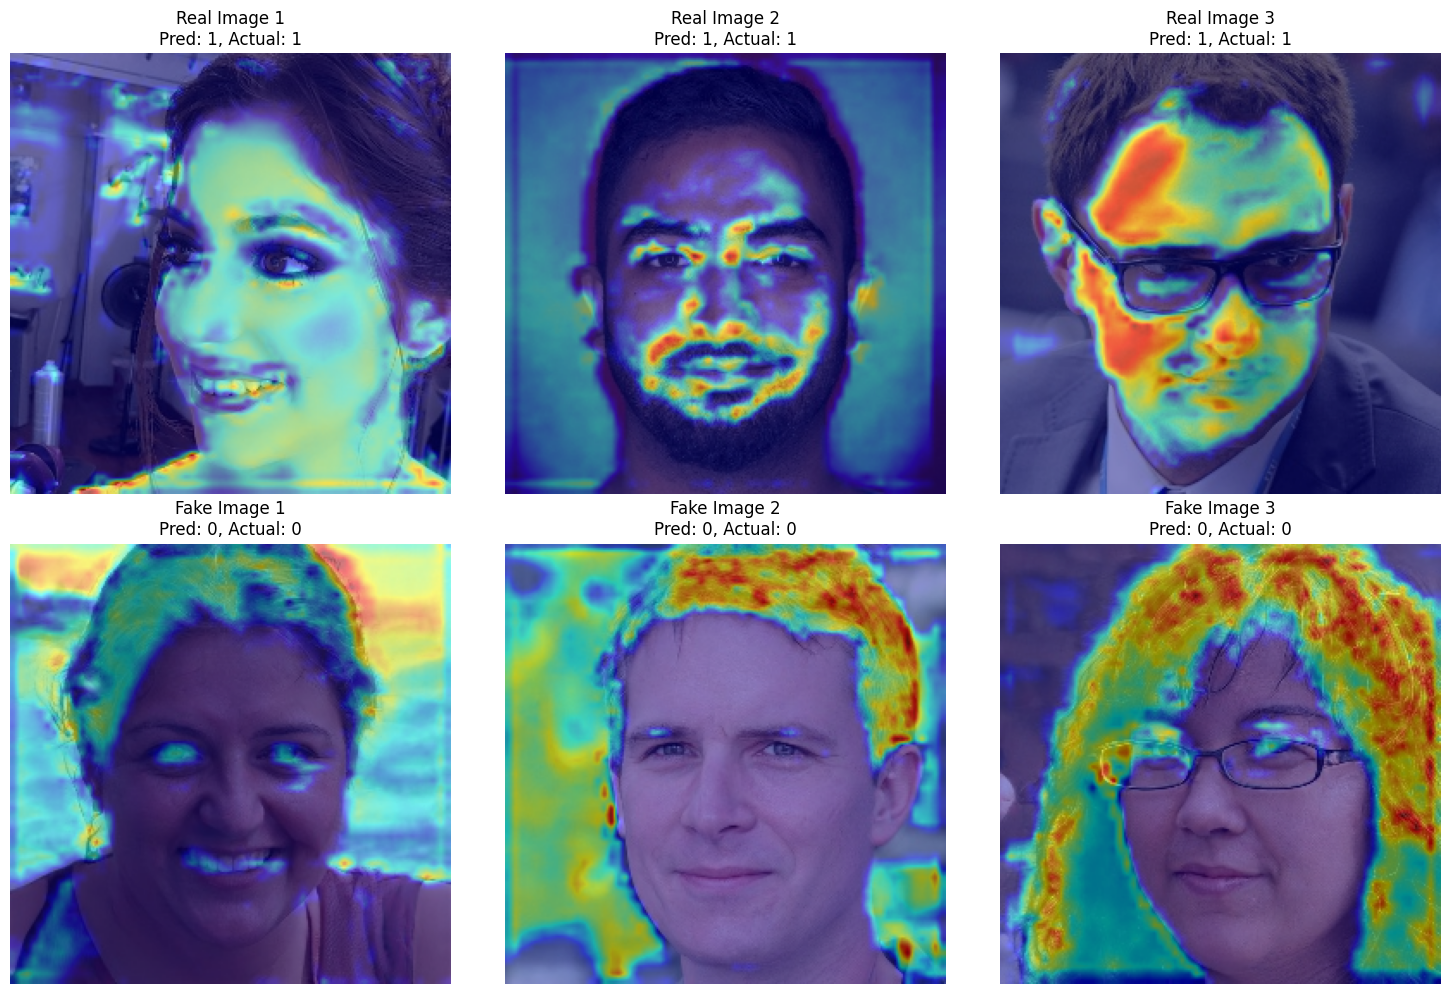

In [38]:
target_layer = augmented_model3.conv4
get_grad_cam_images(augmented_model3, transform, target_layer, real_imgs_to_show, fake_imgs_to_show, '/content/drive/MyDrive/DataAugmentation/augmented_model_gradcam.png')

Here we merge the results from the first three and last two epochs to train  `augmented_model3`:


In [41]:
augmented_results3['train_losses'].extend(augmented_results3_continuation['train_losses'])
augmented_results3['val_losses'].extend(augmented_results3_continuation['val_losses'])
augmented_results3['train_accuracies'].extend(augmented_results3_continuation['train_accuracies'])
augmented_results3['val_accuracies'].extend(augmented_results3_continuation['val_accuracies'])
augmented_results3['true_labels'].extend(augmented_results3_continuation['true_labels'])
augmented_results3['pred_labels'].extend(augmented_results3_continuation['pred_labels'])
augmented_results3['probs'].extend(augmented_results3_continuation['probs'])
augmented_results3['test_true_labels'].extend(augmented_results3_continuation['test_true_labels'])
augmented_results3['test_predictions'].extend(augmented_results3_continuation['test_predictions'])
augmented_results3['accuracy'] = augmented_results3_continuation['accuracy']
augmented_results3['precision'] = augmented_results3_continuation['precision']
augmented_results3['recall'] = augmented_results3_continuation['recall']
augmented_results3['f1'] = augmented_results3_continuation['f1']
augmented_results3['roc_auc'] = augmented_results3_continuation['roc_auc']
augmented_results3['conf_matrix'] = augmented_results3_continuation['conf_matrix']
augmented_results3['test_conf_matrix'] = augmented_results3_continuation['test_conf_matrix']

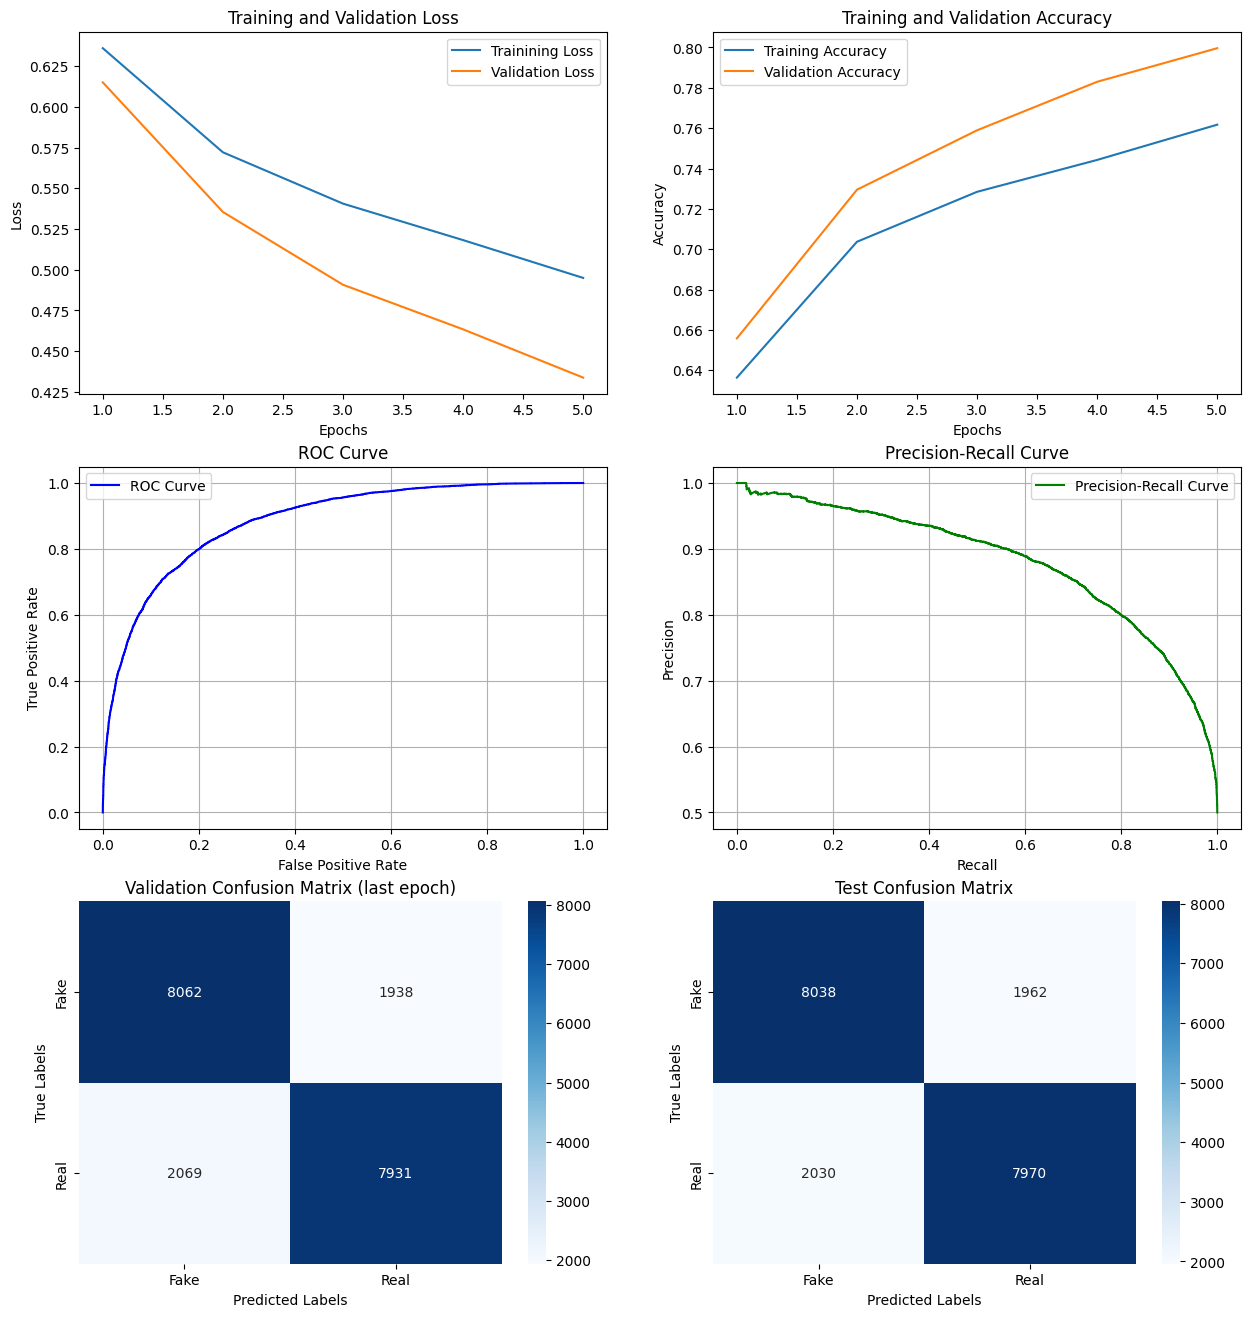

In [43]:
plot_figures(augmented_results3, '/content/drive/MyDrive/DataAugmentation/augmented_model_figures.png', 5)

In [44]:
torch.save(augmented_results3, '/content/drive/MyDrive/DataAugmentation/augmented_model.pth')

### Saving Grad-CAM images for analysis

100 images, 50 real ones and 50 fake ones, then use our model to classify them and apply Grad-CAM during the process. Since the images are a lot, we will not display them here, and instead save them in four different folders, both in their Grad-CAM and original versions:
- `true-real-pred-real`: True Positives
- `true-real-pred-false`: False Negatives
- `true-false-pred-real`: False Positives
- `true-false-pred-false`: True Negatives

In [54]:
# Sample 50 real images
real_paths = random.sample(list(train_df[train_df.label == 1].image_path), 50)

# Sample 50 fake images
fake_paths = random.sample(list(train_df[train_df.label == 0].image_path), 50)

# Read the images from the paths
real_images = [Image.open(path) for path in real_paths]
fake_images = [Image.open(path) for path in fake_paths]

# Get model preditions for the real images
real_predictions = [augmented_model3(transform(image).unsqueeze(0).to(device)).argmax(dim=1).item() for image in real_images]

# Get model predictions for fake images
fake_predictions = [augmented_model3(transform(image).unsqueeze(0).to(device)).argmax(dim=1).item() for image in fake_images]

target_layer = augmented_model3.conv4

# Save images + Grad-CAM images into the True Positive and False Negative folders based on predictions
for i, (image, prediction) in enumerate(zip(real_images, real_predictions)):
    grad_cam_image, _ = Grad_CAM(augmented_model3, transform, target_layer, real_paths[i])
    if prediction == 1:
        image.save(f'/content/drive/MyDrive/Predictions/true-real-pred-real/real_{i}.png')
        plt.imshow(grad_cam_image)
        plt.axis('off')
        plt.savefig(f'/content/drive/MyDrive/Grad-CAM/true-real-pred-real/grad_cam_real_{i}.png')
        plt.close()
        #Image.fromarray((grad_cam_image * 255).astype(np.uint8)).save(f'/content/drive/MyDrive/Grad-CAM/true-real-pred-real/grad_cam_real_{i}.png')
    else:
        image.save(f'/content/drive/MyDrive/Predictions/true-real-pred-false/real_{i}.png')
        plt.imshow(grad_cam_image)
        plt.axis('off')
        plt.savefig(f'/content/drive/MyDrive/Grad-CAM/true-real-pred-false/grad_cam_real_{i}.png')
        plt.close()
        #Image.fromarray((grad_cam_image * 255).astype(np.uint8)).save(f'/content/drive/MyDrive/Grad-CAM/true-real-pred-false/grad_cam_real_{i}.png')

# Save images + Grad-CAM images into the False Positive and True Negative folders based on predictions
for i, (image, prediction) in enumerate(zip(fake_images, fake_predictions)):
    grad_cam_image, _ = Grad_CAM(augmented_model3, transform, target_layer, fake_paths[i])
    if prediction == 1:
        image.save(f'/content/drive/MyDrive/Predictions/true-false-pred-real/fake_{i}.png')
        plt.imshow(grad_cam_image)
        plt.axis('off')
        plt.savefig(f'/content/drive/MyDrive/Grad-CAM/true-false-pred-real/grad_cam_fake_{i}.png')
        plt.close()
        #Image.fromarray((grad_cam_image * 255).astype(np.uint8)).save(f'/content/drive/MyDrive/Grad-CAM/true-false-pred-real/grad_cam_fake_{i}.png')
    else:
        image.save(f'/content/drive/MyDrive/Predictions/true-false-pred-false/fake_{i}.png')
        plt.imshow(grad_cam_image)
        plt.axis('off')
        plt.savefig(f'/content/drive/MyDrive/Grad-CAM/true-false-pred-false/grad_cam_fake_{i}.png')
        plt.close()
        #Image.fromarray((grad_cam_image * 255).astype(np.uint8)).save(f'/content/drive/MyDrive/Grad-CAM/true-false-pred-false/grad_cam_fake_{i}.png')

We can also analyze some more resnet50 Grad-CAM images. For this we load the model that we previously pre-trained.

In [63]:
# Load ResNet50
resnet50 = models.resnet50()

# Modify the final fully connected layer for binary classification
num_features = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_features, 2)  # Output logits for 2 classes

resnet50_results = torch.load('/content/drive/MyDrive/resnet50/results_CE_SGD_001_mom.pth')
resnet50_weights = resnet50_results['model_state_dict']
resnet50.load_state_dict(resnet50_weights)

<ipython-input-63-e9e9068d59ff>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet50_results = torch.load('/content/drive/MyDrive/resnet50/results_CE_SGD_001_mom.pth')


<All keys matched successfully>

In [ ]:
resnet50.to(device)

Now we repeat the procedure we did for the Custom CNN, generating Grad-CAM images and saving them in folders based on their true and predicted labels.

In [66]:
# Sample 50 real images
real_paths = random.sample(list(train_df[train_df.label == 1].image_path), 50)

# Sample 50 fake images
fake_paths = random.sample(list(train_df[train_df.label == 0].image_path), 50)

# Read the images from the paths
real_images = [Image.open(path) for path in real_paths]
fake_images = [Image.open(path) for path in fake_paths]

# Get model preditions for the real images
real_predictions = [resnet50(transform(image).unsqueeze(0).to(device)).argmax(dim=1).item() for image in real_images]

# Get model predictions for fake images
fake_predictions = [resnet50(transform(image).unsqueeze(0).to(device)).argmax(dim=1).item() for image in fake_images]

target_layer = resnet50.layer4[-1].conv3

# Save images + Grad-CAM images into the True Positive and False Negative folders based on predictions
for i, (image, prediction) in enumerate(zip(real_images, real_predictions)):
    grad_cam_image, _ = Grad_CAM(resnet50, transform, target_layer, real_paths[i])
    if prediction == 1:
        image.save(f'/content/drive/MyDrive/resnet50/Predictions/true-real-pred-real/real_{i}.png')
        plt.imshow(grad_cam_image)
        plt.axis('off')
        plt.savefig(f'/content/drive/MyDrive/resnet50/Grad-CAM/true-real-pred-real/grad_cam_real_{i}.png')
        plt.close()
        #Image.fromarray((grad_cam_image * 255).astype(np.uint8)).save(f'/content/drive/MyDrive/Grad-CAM/true-real-pred-real/grad_cam_real_{i}.png')
    else:
        image.save(f'/content/drive/MyDrive/resnet50/Predictions/true-real-pred-fake/real_{i}.png')
        plt.imshow(grad_cam_image)
        plt.axis('off')
        plt.savefig(f'/content/drive/MyDrive/resnet50/Grad-CAM/true-real-pred-fake/grad_cam_real_{i}.png')
        plt.close()
        #Image.fromarray((grad_cam_image * 255).astype(np.uint8)).save(f'/content/drive/MyDrive/Grad-CAM/true-real-pred-false/grad_cam_real_{i}.png')

# Save images + Grad-CAM images into the False Positive and True Negative folders based on predictions
for i, (image, prediction) in enumerate(zip(fake_images, fake_predictions)):
    grad_cam_image, _ = Grad_CAM(resnet50, transform, target_layer, fake_paths[i])
    if prediction == 1:
        image.save(f'/content/drive/MyDrive/resnet50/Predictions/true-fake-pred-real/fake_{i}.png')
        plt.imshow(grad_cam_image)
        plt.axis('off')
        plt.savefig(f'/content/drive/MyDrive/resnet50/Grad-CAM/true-fake-pred-real/grad_cam_fake_{i}.png')
        plt.close()
        #Image.fromarray((grad_cam_image * 255).astype(np.uint8)).save(f'/content/drive/MyDrive/Grad-CAM/true-false-pred-real/grad_cam_fake_{i}.png')
    else:
        image.save(f'/content/drive/MyDrive/resnet50/Predictions/true-fake-pred-fake/fake_{i}.png')
        plt.imshow(grad_cam_image)
        plt.axis('off')
        plt.savefig(f'/content/drive/MyDrive/resnet50/Grad-CAM/true-fake-pred-fake/grad_cam_fake_{i}.png')
        plt.close()
        #Image.fromarray((grad_cam_image * 255).astype(np.uint8)).save(f'/content/drive/MyDrive/Grad-CAM/true-false-pred-false/grad_cam_fake_{i}.png')

### Training the CNN on blurred images

So far, we have trained models on the original dataset and applied data augmentation through flipping and rotating the image and modifying the colors, to make a model robust against changes.

The next question is: what happens if we blur images?

From the Grad-CAM images saved in the folders, it appears that models especially focus on details in the hair and eyes when predicting that an image is fake, while focusing on the skin to determine if it is real. The differences are on the level of pixels, so we want to explore what happens when those differences become blurry.

In [56]:
# Transformation with gaussian blur
blur_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image if needed
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), # Add a little Gaussian blur
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# save new blurry train dataset and data loader instances
blur_train_dataset = FaceDataset(dataframe=train_df, transform=blur_transform)
blur_train_loader = DataLoader(blur_train_dataset, batch_size=64, shuffle=True)

We first use our previously trained model, which we already retrieved earlier in the code, and test it on the blurry data.

In [57]:
blurry_model = copy.deepcopy(model)
testing(blur_train_loader, blurry_model) # here we use blur_train_loader because we just want to see how the model performs if we blur images
# the training dataset is not to be used during testing, but this model was trained on the original images, while these are blurred


Test Results
Test Accuracy: 0.5000
Test Precision: 0.5000
Test Recall: 1.0000
Test F1 Score: 0.6667
Test ROC AUC: 0.5000


The results are awful, which again shows that our previously trained models were not robust enough against change in the data. So we will train our CNN on the blurred images now.

In [59]:
blurry_model, blurry_results1 = experiment(blur_train_loader, valid_loader, test_loader, blurry_model, loss_function='BCEWithLogitsLoss', optimizer='SGD', lr=0.001, momentum=0.9, num_epochs=2)

Epoch 1: Training Loss = 0.6932, Training Accuracy = 0.4992
Epoch 1: Validation Loss = 0.6931, Validation Accuracy = 0.5000
Epoch 2: Training Loss = 0.6932, Training Accuracy = 0.4992
Epoch 2: Validation Loss = 0.6932, Validation Accuracy = 0.5000
Finished Training

Test Results
Test Accuracy: 0.5000
Test Precision: 0.5000
Test Recall: 1.0000
Test F1 Score: 0.6667
Test ROC AUC: 0.5000

Classification Report:
               precision    recall  f1-score   support

        Fake       0.00      0.00      0.00     10000
        Real       0.50      1.00      0.67     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


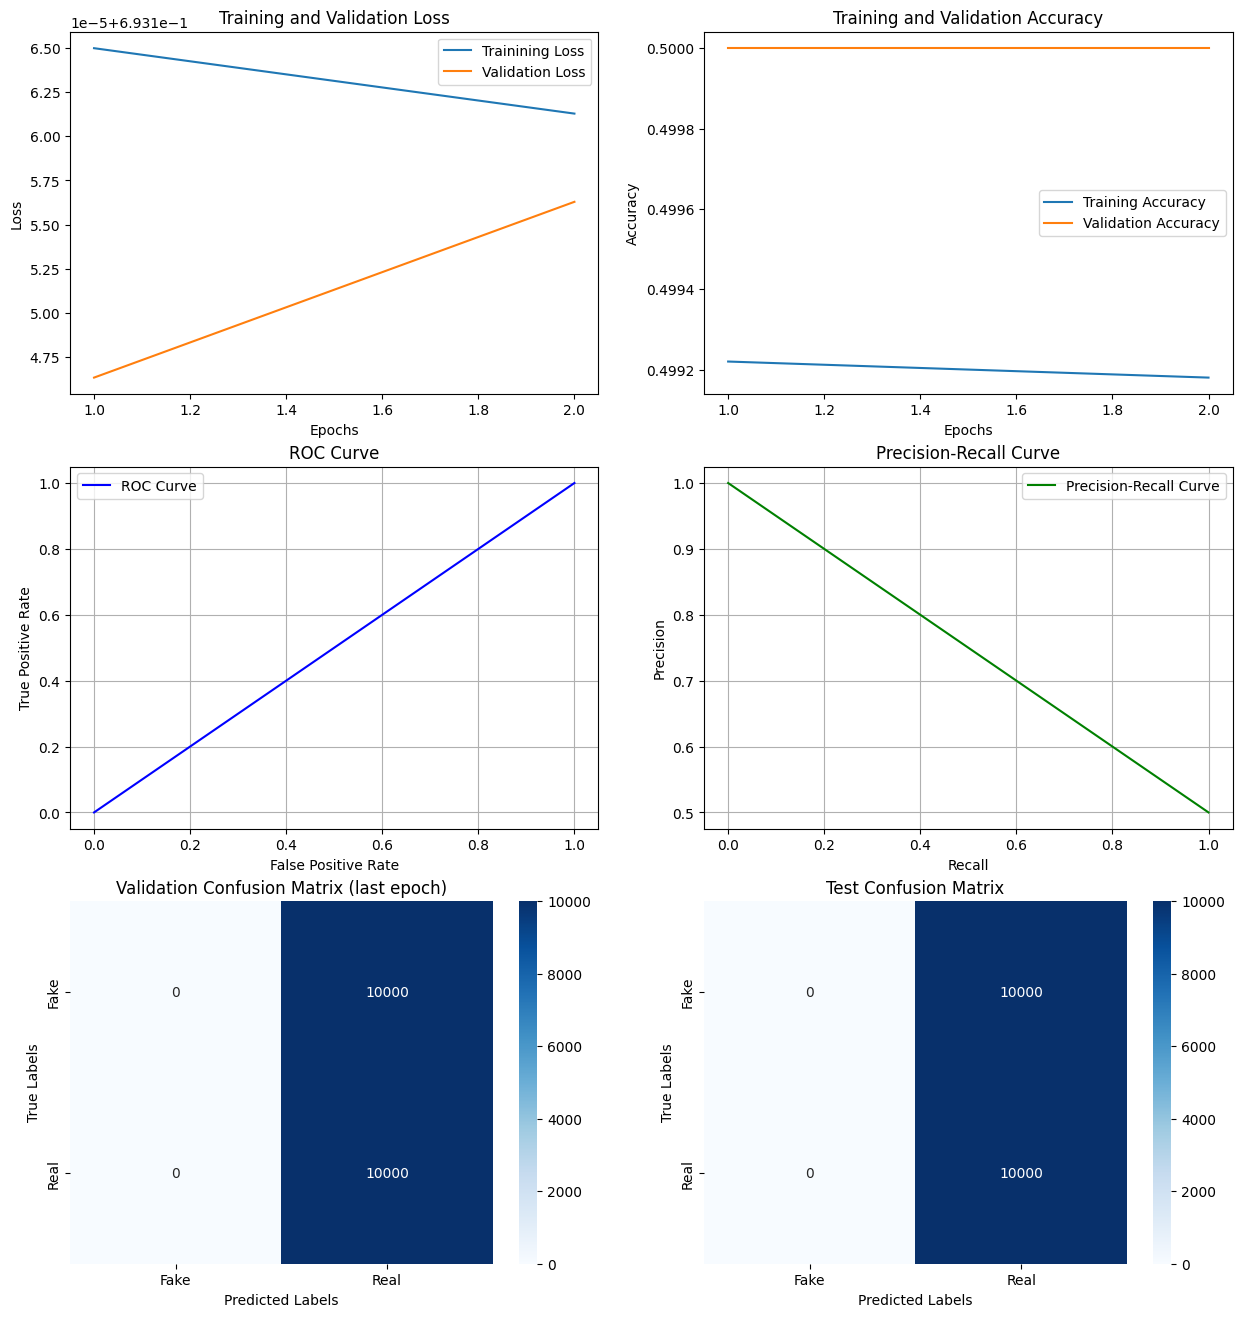

In [61]:
plot_figures(blurry_results1, '/content/drive/MyDrive/DataAugmentation/blurry_model_figures.png', 2)

Despite the re-training, it is clear that the model fails completely at classifying blurred real and fake faces.

We can try to see if the pre-trained resnet50 performs better.

In [67]:
blurry_resnet50 = copy.deepcopy(resnet50)
blurry_resnet50, blurry_resnet50_results1 = experiment(blur_train_loader, valid_loader, test_loader, blurry_resnet50, loss_function = 'CrossEntropyLoss', optimizer = 'SGD', lr=0.001, momentum=0.9, num_epochs=2)

Epoch 1: Training Loss = 0.1054, Training Accuracy = 0.9604
Epoch 1: Validation Loss = 0.0269, Validation Accuracy = 0.9910
Epoch 2: Training Loss = 0.0373, Training Accuracy = 0.9867
Epoch 2: Validation Loss = 0.0187, Validation Accuracy = 0.9936
Finished Training

Test Results
Test Accuracy: 0.9931
Test Precision: 0.9905
Test Recall: 0.9957
Test F1 Score: 0.9931
Test ROC AUC: 0.9931

Classification Report:
               precision    recall  f1-score   support

        Fake       1.00      0.99      0.99     10000
        Real       0.99      1.00      0.99     10000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



While our model failed the challenge, ResNet-50 is robust enough to handle some Gaussian blur.

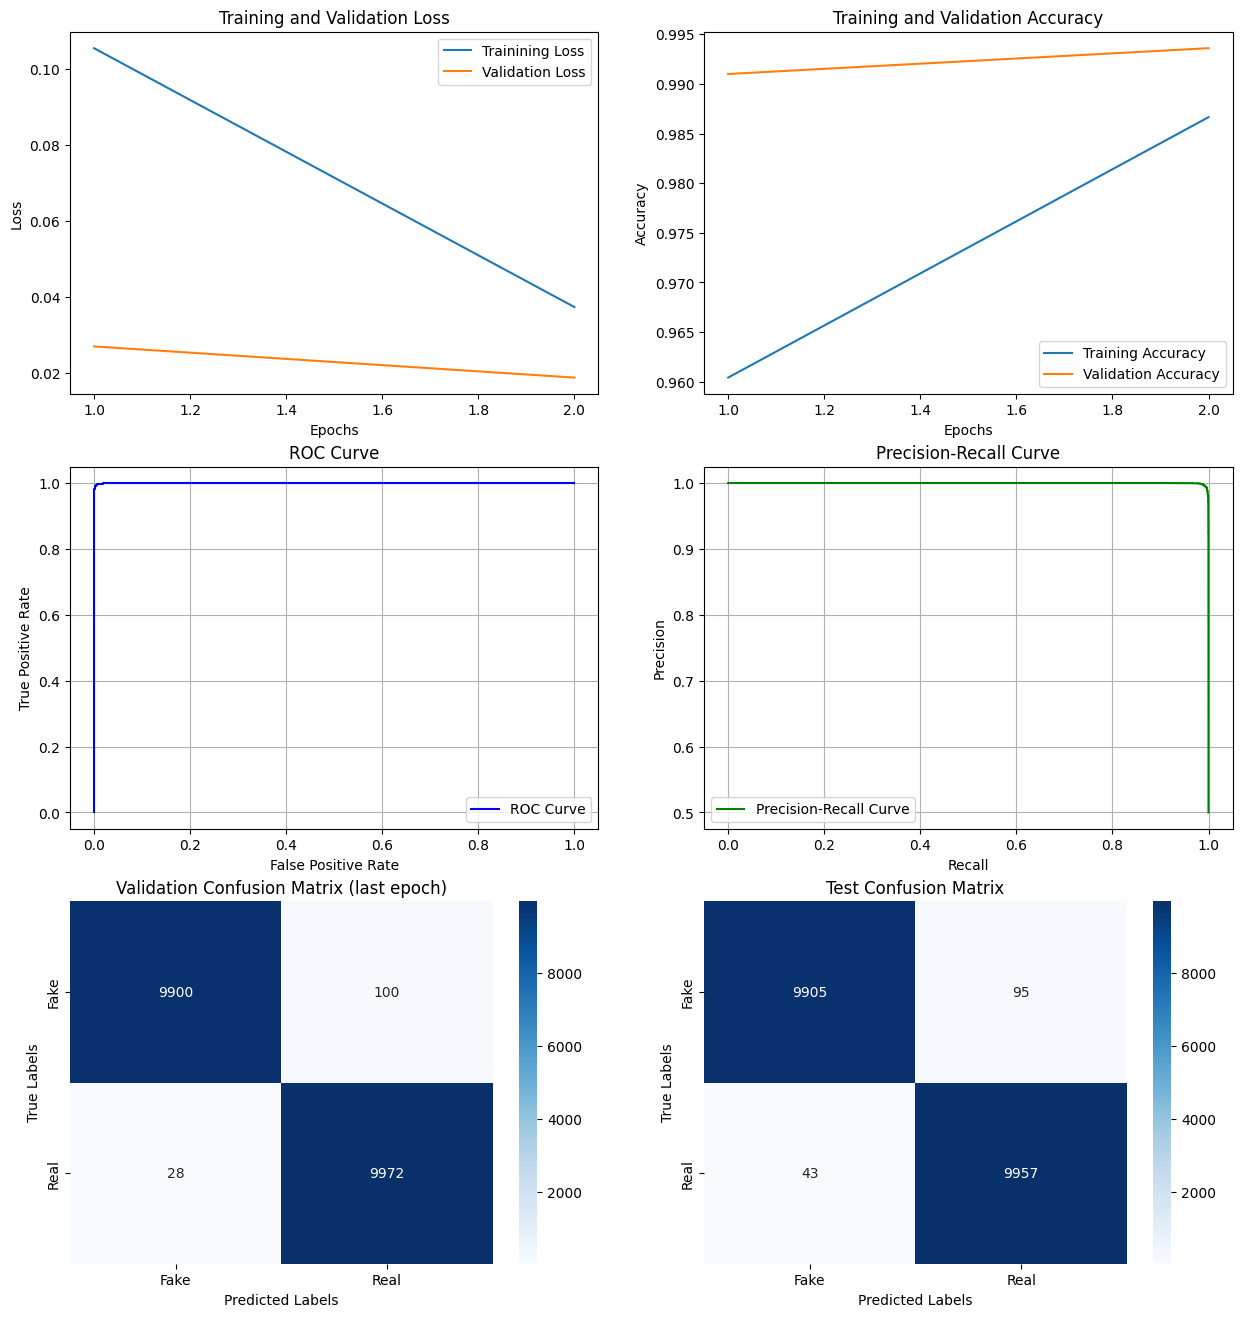

In [68]:
plot_figures(blurry_resnet50_results1, '/content/drive/MyDrive/DataAugmentation/blurry_resnet_figures.png', 2)

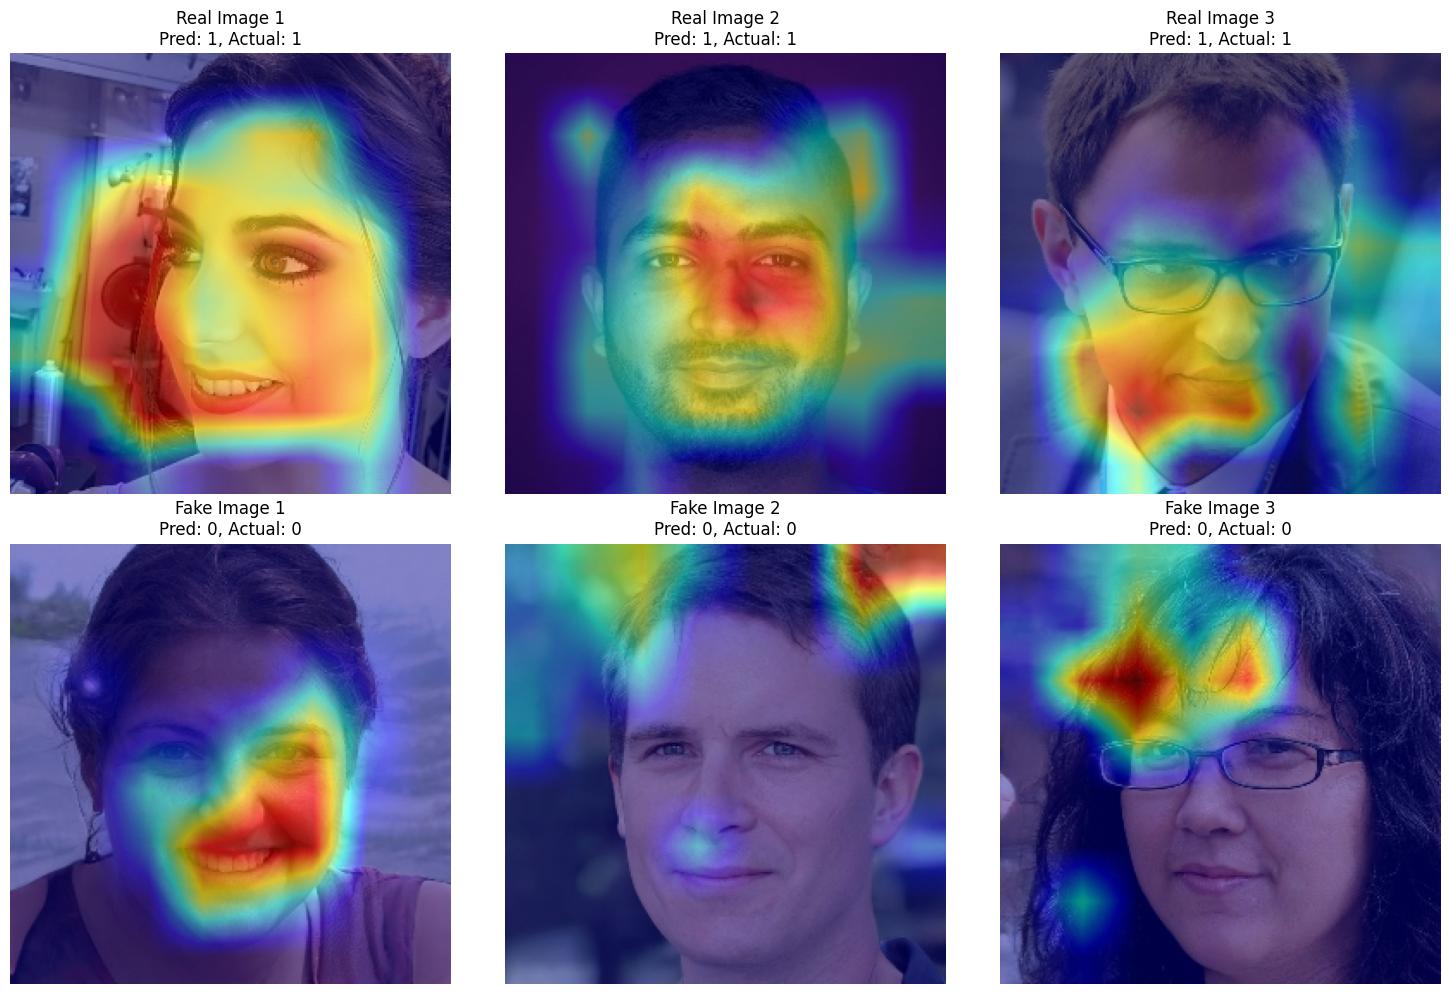

In [71]:
target_layer = blurry_resnet50.layer4[-1].conv3
get_grad_cam_images(blurry_resnet50, transform, target_layer, real_imgs_to_show, fake_imgs_to_show, '/content/drive/MyDrive/DataAugmentation/grad_cam_blurry_resnet50.png')

In [72]:
torch.save(blurry_resnet50_results1, '/content/drive/MyDrive/DataAugmentation/results_blurry_resnet50.png')